In [1]:
import glob,os
import numpy as np
import pandas as pd
import re
from fitsio import FITS

# import astropy
from astropy.table import Table, setdiff, vstack,join

import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.71
file_path = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/DepthData/FixedDepth-60/"

filepath = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/" #
filepath1 = r"/bsuscratch/shuleicao/Cardinalv3/"

# Load the cylinder richness data of the different depths

In [2]:
def load_and_process_data(file_path, varying_quantity):
    filename = f"RichnessDepth-Data/RichnessDepth_{varying_quantity}_60_035_05.dat"
    data_unsorted = Table.read(file_path + filename, format='ascii')
    
    data_sorted = Table(np.sort(data_unsorted, order='lam'))[::-1]
    print(f'D{varying_quantity}' ,len(data_sorted), len(np.unique(data_sorted['pixelid'])))
    
    return data_sorted

# Load and process richness data for different depths
clusterCC9 = load_and_process_data(file_path, 'ColorCut9')  ### CC=Color Cut
clusterCC20 = load_and_process_data(file_path, 'ColorCut20')
clusterCC50 = load_and_process_data(file_path, 'ColorCut50')
clusterCC100 = load_and_process_data(file_path, 'ColorCut100')
clusterCC500 = load_and_process_data(file_path, 'ColorCut500')

DColorCut9 194597 1676
DColorCut20 201126 1677
DColorCut50 201811 1677
DColorCut100 202045 1677
DColorCut500 202400 1677


# Load Halos data with Weak lensing profiles

In [3]:
### Load the halos with the DS and Sigma profiles
sigma_ds_profile =  Table(np.load(filepath+"correctfilev2.npy"))
print(len(sigma_ds_profile))
print(sum(np.all(sigma_ds_profile['Sigma'] == 0, axis=1)))
sigma_ds_profile = sigma_ds_profile[(np.all(sigma_ds_profile['Sigma'] != 0, axis=1)) & (sigma_ds_profile['pid']==-1)]
sigma_ds_profile['Sigma'] = sigma_ds_profile['Sigma']*1e12*h
sigma_ds_profile['DeltaSigma'] = sigma_ds_profile['DeltaSigma']*1e12*h
print(len(sigma_ds_profile))
sigma_ds_profile[:2]

1454571
167514
1208773


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100]
12905996,1104000000000000.0,116.599,18.9969,0.62517,2.1563340659340655,0.464765,-1,0.377642,1129788000000000.0,2.57077,3232607803046852.0 .. 4951584885294.114,225027994363744.4 .. 4491195973346.023,1761882359377507.5 .. 21862032810104.79,-2.0638824814096005e-05 .. 0.6538981002611183,2.6673175421036414e-07 .. 0.0691232562888688,8.064741778139222 .. 1.0457879038100961,287.8731346185066 .. 5.31543402099229
35142654,963800000000000.0,12.3843,15.0544,0.62133,2.0602021978021976,0.673965,-1,0.409137,991244500000000.0,2.46113,1.1785172540359254e+16 .. 8011401459616.633,228034835634536.3 .. 3157197076052.113,2073043573443353.5 .. 21317607969554.035,0.0 .. 0.1991121235725387,0.0 .. 0.06996756822056328,8.109481193785157 .. 1.0461027816248183,287.34227585727774 .. 5.351987610686462


# Load cluster-halos matched (RedMaPPer)

In [5]:
cluster_halos_red = Table(np.load(filepath + "HaloRun_Halo_Clusters_Lamgt20-20110.npy")) #HaloRun_Halo_Clusters-_Lamgt0-1081991.npy
cluster_halos_red = Table(join(sigma_ds_profile,cluster_halos_red, keys_right=['halo_id','m200'],keys_left=['haloid','Mvir']))
# cluster_halos_red = cluster_halos_red[np.all(cluster_halos_red['Sigma'] != 0, axis=1)]
print(len(cluster_halos_red))
cluster_halos_red = cluster_halos_red[(cluster_halos_red['z']>=0.35) & (cluster_halos_red['z']<0.5) & (cluster_halos_red['lambda']>=10)]
cluster_halos_red = Table(np.sort(cluster_halos_red,order='lambda'))[::-1]
print(len(cluster_halos_red))

lamranges = [(10,30), (30,45), (45,60), (60,500)]
lamlabels = ['(20,30]', '(30,45]', '(45,60]', '(60,500]']
cluster_halos_red['lambda_range'] = pd.cut(cluster_halos_red['lambda'], bins=[r[0] for r in lamranges] + [lamranges[-1][-1]], labels=lamlabels)
grouped_cl_halos_red = cluster_halos_red.group_by(['lambda_range'])

cluster_halos_red[:2]

7820
3237


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta,halo_id,id,m200,ra,dec,z,refmag,refmag_err,mag,mag_err,mem_match_id,lambda,lambda_e,z_lambda,z_lambda_e,cg_spec_z,z_spec_init,z_init,r_lambda,r_mask,scaleval,maskfrac,zred,zred_e,zred_chisq,chisq,z_lambda_niter,ebv_mean,lnlamlike,lncglike,lnlike,ra_orig,dec_orig,w,dlambda_dz,dlambda_dz2,dlambdavar_dz,dlambdavar_dz2,z_lambda_raw,z_lambda_e_raw,bkg_local,lim_exptime,lim_limmag,lim_limmag_hard,lambda_c,lambda_ce,ncent_good,maskgal_index,pzbins,pz,ra_cent,dec_cent,id_cent,lambda_cent,zlambda_cent,p_cen,q_cen,p_fg,q_miss,p_sat,p_c,lambda_range
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100],int64,int64,float32,float64,float64,float32,float32,float32,float32[4],float32[4],int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32[21],float32[21],float64[5],float64[5],int64[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32[5],float32[5],object
17190342,596400000000000.0,90.4077,36.7045,0.451895,1.9160137457044673,0.64002,-1,0.218077,617193000000000.0,2.10164,1.178652917398597e+16 .. 3860472906040.4775,98124957833030.98 .. 18442434394.316475,1735417870808115.0 .. 11838424794268.486,0.0 .. 0.36156430102208176,0.0 .. 0.12219445183713944,8.989846112392373 .. 1.0,152.73673319535305 .. 0.0,17190342,383002578722,596400000000000.0,19.321811694173213,-30.976452418943822,0.45109573,21.086771,0.032984868,23.699495 .. 21.086771,0.06817315 .. 0.032984868,277,219.63008,5.5323234,0.4497038,0.008026683,0.45109573,0.0,0.0,1.1704109,1.7556164,1.0313463,0.034147203,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.6267817,-489.67596,110.58986,548.20874,0.0,0.0,0.0,0.38509983,22.832195,23.33665,0.0,0.0,0,56,0.40586442 .. 0.4935432,6.2841515e-05 .. 5.6128583e-06,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,"(60,500]"
23317182,413400000000000.0,56.3268,15.9587,0.432248,1.7137680438028866,0.493089,-1,0.246538,425863200000000.0,1.85698,8366027870199474.0 .. 2057703961179.417,379868077118782.3 .. 2278852413863.7173,1445082383736526.5 .. 17502405857691.969,0.0 .. 0.22790811840892117,0.0 .. 0.131959078708079,8.506881947037705 .. 1.0,117.75161886889164 .. 0.0,23317182,4002836575,413400000000000.0,52.72663069017093,-11.31614337981297,0.42866796,17.568909,0.0070974533,20.366562 .. 17.568909,0.012598149 .. 0.0070974533,1028,195.55772,6.045732,0.4432992,0.008255182,0.42866796,0.0,0.0,1.1435496,1.7153244,1.0509124,0.05077776,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0810957,3005.5925,93.761154,122158.85,0.0,0.0,0.0,0.2518322,22.361485,23.33665,0.0,0.0,0,92,0.39930713 .. 0.48729125,0.0002193814 .. 5.764628e-06,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,"(60,500]"


# Merge halos with clusters (DepthMapper)

In [7]:
# List of cluster tables and suffix values
# clusterCC9, clusterCC20, clusterCC50, clusterCC100, clusterCC500, clusterZC0101, clusterZC0303, clusterZC11
cluster_tables = [clusterCC9, clusterCC20, clusterCC50, clusterCC100, clusterCC500]  #0, cluster_150, cluster_180, cluster_210
suffix_values = [ 9, 20, 50, 100, 500] #, 150, 180, 210   9, 20, 50, 100, 500, '0101', '0303', 11

halo_cluster_tables = {}

# Iterate over the tables and suffix values
for i, (cluster_table, suffix) in enumerate(zip(cluster_tables, suffix_values), 1):
    halo_table_name = f"cluster_halo_{suffix}"

    # Perform the join and other operations 
    halo_table = Table(np.sort(join(cluster_table, sigma_ds_profile, keys_left=['haloid','redshift'], keys_right=['haloid','Redshift'], join_type='inner')))[::-1]
    halo_cluster_tables[halo_table_name] = halo_table #[np.unique(halo_table['haloid_1'], return_index=True)[1]]

    print(f"Length of {halo_table_name}: {len(halo_table)}")

cluster_halo_CC9 = Table(halo_cluster_tables['cluster_halo_9'])
cluster_halo_CC20 = Table(halo_cluster_tables['cluster_halo_20'])
cluster_halo_CC50 = Table(halo_cluster_tables['cluster_halo_50'])
cluster_halo_CC100 = Table(halo_cluster_tables['cluster_halo_100'])
cluster_halo_CC500 = Table(halo_cluster_tables['cluster_halo_500'])

Length of cluster_halo_9: 152148
Length of cluster_halo_20: 158134
Length of cluster_halo_50: 158754
Length of cluster_halo_100: 158923
Length of cluster_halo_500: 159205


In [8]:
Rmin_phys_mpc = 0.0323
Rmax_phys_mpc = 30
nbins_phys_mpc = 15
lnrp_bins_phys_mpc = np.linspace(np.log(Rmin_phys_mpc), np.log(Rmax_phys_mpc), nbins_phys_mpc+1)
rp_bins_phys_mpc = np.exp(lnrp_bins_phys_mpc)
rp_phys_mpc = np.sqrt(rp_bins_phys_mpc[:-1]*rp_bins_phys_mpc[1:])
bins = rp_phys_mpc  #rp

In [9]:
## Weighted Profile
def stacked_profile_weighted_by_mass_redshift(lnM_select, z_select, prof_select, lnM_all, z_all, profile_A, dm=0.1, dz=0.05):
    #### set up the bins for mass and redshift  (sigma_select/profile_select, sigma_all/profile_all)
    min_m = min(lnM_select)#-dm
    max_m = max(lnM_select)#+dm
    min_z = min(z_select)#-dz
    max_z = max(z_select)#+dz

    # print('z', min_z, max_z)
    m_bins = np.arange(min_m, max_m+dm, dm)
    z_bins = np.arange(min_z, max_z+dz, dz)
    nM = len(m_bins)-1
    nz = len(z_bins)-1
    # print('nM, nz', nM, nz)

    profile_select = np.array([i.tolist() for i in prof_select])
    profile_all = np.array([i.tolist() for i in profile_A])

    nr = np.shape(profile_select)[1]#rbp.nbins_phys_mpc...1
    profile_weighted = np.zeros(nr)
    weight_norm = 0


    pdf1_list = np.zeros([nz, nM]) # see how many bins are too narrow
    pdf2_list = np.zeros([nz, nM]) # see how many bins are too narrow

    for iz in range(nz):
        z_lo = z_bins[iz]
        z_hi = z_bins[iz+1]
        for iM in range(nM):
            m_lo = m_bins[iM]
            m_hi = m_bins[iM+1]
            
            select_bin = (lnM_select >= m_lo)&(lnM_select < m_hi)&(z_select>=z_lo)&(z_select<z_hi)
            weight = len(lnM_select[select_bin]) * 1.
            weight_norm += weight
            select_all = (lnM_all >= m_lo)&(lnM_all < m_hi)&(z_all>=z_lo)&(z_all<z_hi)

            pdf1_list[iz, iM] = weight
            pdf2_list[iz, iM] = len(lnM_all[select_all])

            if weight > 0 and len(lnM_all[select_all]) > 0:
                profile_weighted += (np.mean(profile_all[select_all, :], axis=0)*weight)
    profile_weighted /= weight_norm

    pdf1_list = np.concatenate(pdf1_list)
    pdf2_list = np.concatenate(pdf2_list)
    diff_list = pdf2_list - pdf1_list

    return profile_weighted

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

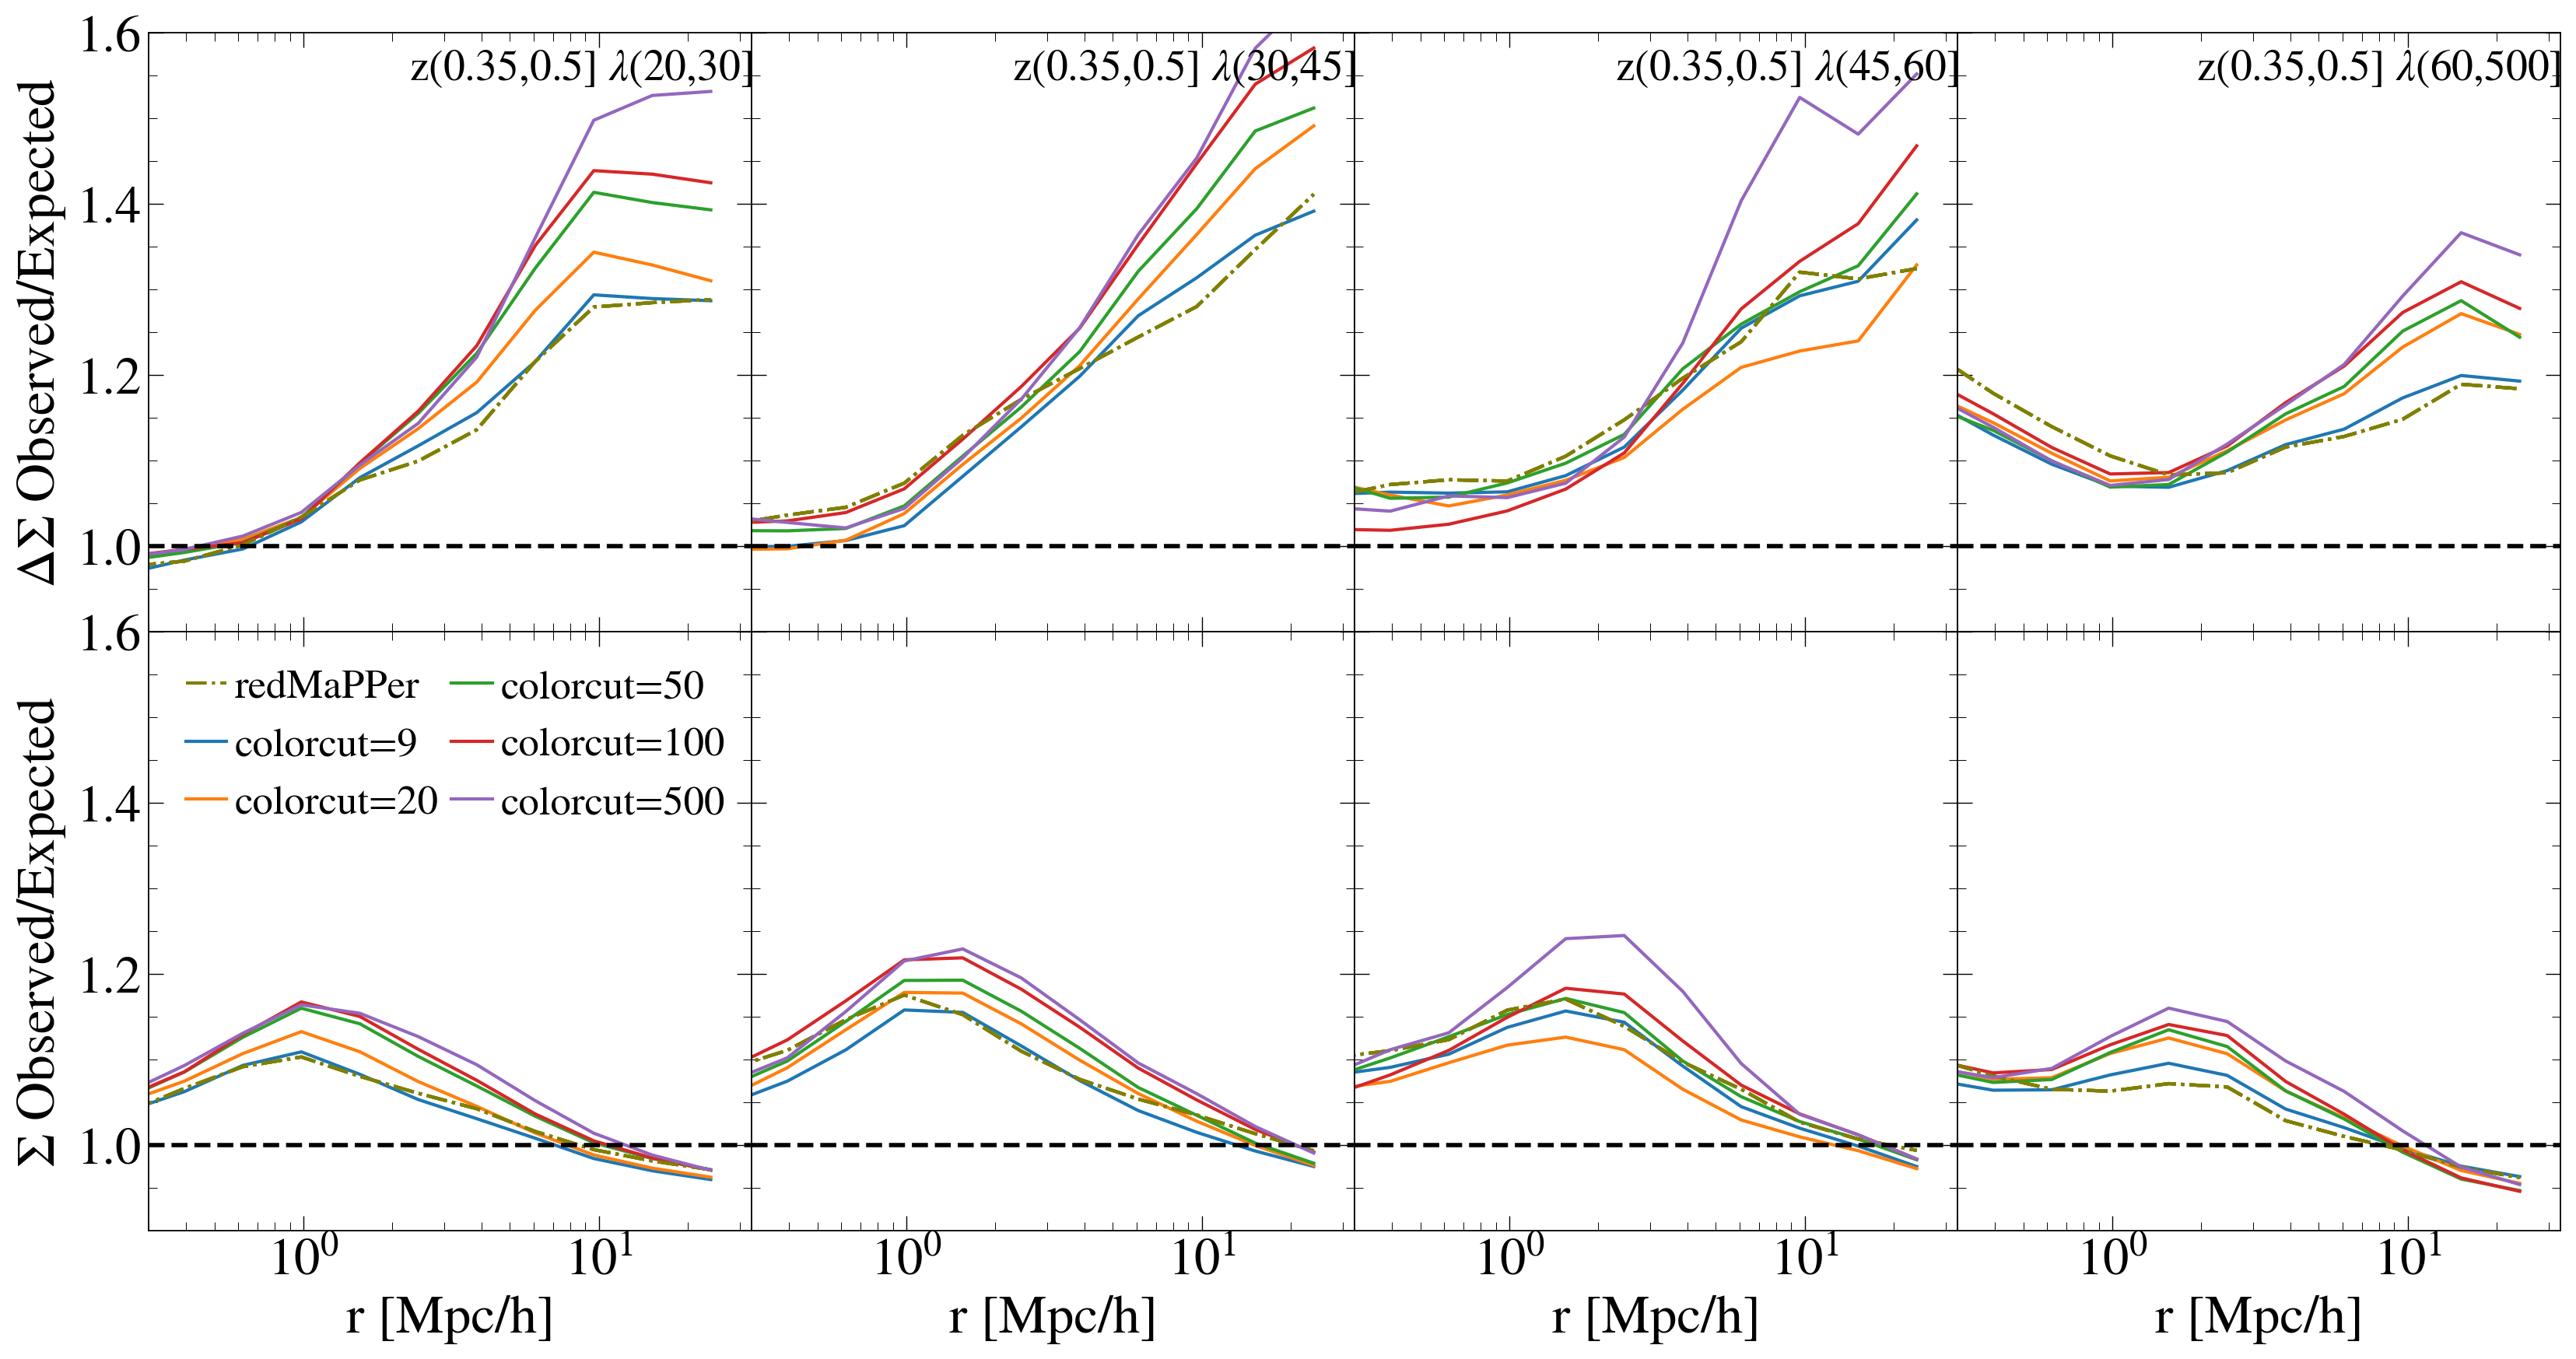

In [10]:
underlying_halos = sigma_ds_profile[(sigma_ds_profile['Redshift'] >= 0.35) & (sigma_ds_profile['Redshift'] < 0.5)]
lnM_All = np.log10(underlying_halos['Mvir'])
z_All = underlying_halos['Redshift']
profile_All = underlying_halos['Sigma']
profile_All_ds = underlying_halos['DeltaSigma']

# Function to select clusters based on lambda values and calculate ratios
def select_and_calculate_ratios(cluster_halo, num_clusters_in_bin, lnM_All, z_All, profile_All_ds, profile_All):
    sorted_indices = np.argsort(np.array(cluster_halo['lam']))[::-1]
    sel_clusters = cluster_halo[sorted_indices[:num_clusters_in_bin]]
    cluster_halo.remove_rows(sorted_indices[:num_clusters_in_bin])
    
    lnM_sel = np.log10(sel_clusters['mass'])
    z_sel = sel_clusters['redshift']
    profile_sel = sel_clusters['Sigma']
    profile_sel_ds = sel_clusters['DeltaSigma']
    
    expected_ds = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel_ds, lnM_All, z_All, profile_All_ds)
    expected_sigma = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel, lnM_All, z_All, profile_All)
    
    ratio_ds = np.array(profile_sel_ds.mean(axis=0)) / np.array(expected_ds)
    ratio_sigma = np.array(profile_sel.mean(axis=0)) / np.array(expected_sigma)
    
    return ratio_ds, ratio_sigma

# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
D = [ 'colorcut=9', 'colorcut=20', 'colorcut=50', 'colorcut=100', 'colorcut=500'] ## 'CC9', 'CC20', 'CC50', 'CC100', 'CC500','ZC0101', 'ZC0303', 'ZC11'
markers = ['o', 's', '^', 'D', 'P'] ## , 'D', 'P', '*', 'X', 'v'

for lambda_group in reversed(grouped_cl_halos_red.groups):
    lnM_sel_red = np.log10(lambda_group['Mvir'])
    z_sel_red = lambda_group['z']
    profile_sel_red = lambda_group['Sigma']
    profile_sel_ds_red = lambda_group['DeltaSigma']
    
    num_clusters_in_bin = len(lambda_group)
    
    expected_ds_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_ds_red, lnM_All, z_All, profile_All_ds)
    expected_sigma_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_red, lnM_All, z_All, profile_All)
    
    ratio_ds_red = np.array(profile_sel_ds_red.mean(axis=0)) / np.array(expected_ds_red)
    ratio_sigma_red = np.array(profile_sel_red.mean(axis=0)) / np.array(expected_sigma_red)

    for i, cluster_halo in enumerate([cluster_halo_CC9, cluster_halo_CC20, cluster_halo_CC50, cluster_halo_CC100, cluster_halo_CC500]):
        ratio_ds, ratio_sigma = select_and_calculate_ratios(cluster_halo, num_clusters_in_bin, lnM_All, z_All, profile_All_ds, profile_All)

        # Plotting
        lambda_value = float(re.findall(r'\d+', lambda_group['lambda_range'][0])[0])
        col_index1 = int(lambda_value) // 15 - 1 
        col_index = col_index1 if col_index1 > 0 else 0

        axes[0, col_index].plot(bins, ratio_ds_red, linestyle='dashdot',color='olive')
        axes[0, col_index].plot(bins, ratio_ds)
        axes[0, col_index].set_ylim([0.5, 2])
        axes[0, col_index].grid(visible=False)
        
        axes[1, col_index].plot(bins, ratio_sigma_red, label='redMaPPer' if i == 0 else None, linestyle='dashdot',color='olive')
        axes[1, col_index].plot(bins, ratio_sigma, label=f'{D[i]}')
        axes[1, col_index].set_ylim([0.9, 1.6])
        axes[1, col_index].grid(visible=False)
                                    
    # Set plot properties
    for row_index, ax_row in enumerate(axes):
        ax_row[col_index].set_xscale('log')
        ax_row[col_index].set_ylabel('$\Delta\Sigma$ Observed/Expected' if row_index == 0 else '$\Sigma$ Observed/Expected', fontsize=25)
        ax_row[0].legend(loc='upper left',frameon=False, ncol=2, fontsize=19,
                        handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)

    title = f'z(0.35,0.5] $\lambda${lambda_group["lambda_range"][0]}'
    title_y = 1.1 if row_index > 3 else 0.9
    axes[0, col_index].set_title(title, loc='right', y=title_y, fontsize=20)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axes.flat:
    ax.label_outer()
    ax.tick_params(axis='both', labelsize=24)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2)

# Set the x and y-axis labels for the bottom subplots
for ax in axes[-1, :]:
    ax.set_xlabel('r [Mpc/h]', fontsize=25)

for ax in axes[1, :]:
    ax.set_xlim(0.3, None)

    
filep = r'/bsuhome/gladyskamau/BSU-Research/Cardinal/'
plt.savefig(filep + 'Images/cardinal_D60_ColorCut_bias.png', facecolor='white')
plt.show()


# Load redMaPPer catalog

In [35]:
redmapper_file = FITS(filepath1+"/redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog.fit", mode=0)
redmapper = Table(redmapper_file[1].read())
print(len(redmapper))
redmapper_filtd_un = redmapper[(redmapper['z']>=0.2) & (redmapper['z']<0.35)]
redmapper_filtd = Table(np.sort(redmapper[(redmapper['z']>=0.2) & (redmapper['z']<0.35)], order='lambda')[::-1])
print(len(redmapper_filtd))
redmapper_filtd[:3]

15755
686


mem_match_id,ra,dec,z,refmag,refmag_err,lambda,lambda_e,z_lambda,z_lambda_e,cg_spec_z,z_spec_init,z_init,r_lambda,r_mask,scaleval,maskfrac,zred,zred_e,zred_chisq,chisq,z_lambda_niter,ebv_mean,lnlamlike,lncglike,lnlike,ra_orig,dec_orig,w,dlambda_dz,dlambda_dz2,dlambdavar_dz,dlambdavar_dz2,z_lambda_raw,z_lambda_e_raw,bkg_local,lim_exptime,lim_limmag,lim_limmag_hard,lambda_c,lambda_ce,ncent_good,maskgal_index,mag,mag_err,pzbins,pz,ra_cent,dec_cent,id_cent,lambda_cent,zlambda_cent,p_cen,q_cen,p_fg,q_miss,p_sat,p_c
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32[4],float32[4],float32[21],float32[21],float64[5],float64[5],int64[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32[5],float32[5]
18,35.786259071771504,-60.443601505091664,0.32132468,16.91809,0.004805183,156.96265,5.342838,0.3170013,0.0075480663,0.3193546,0.0,0.3219665,1.0943576,1.6415365,1.0612929,0.059471365,0.3219665,0.0072772168,6.0028315,5.8956156,1,0.0,455.46863,0.0,444.80902,35.786259071771504,-60.443601505091664,2.5971725,4.757706,-1747.733,230.11984,-103527.305,0.0,0.0,0.0,0.30288547,22.566055,23.33665,156.96396,0.0,5,56,19.3945 .. 16.91809,0.007545645 .. 0.004805183,0.27384773 .. 0.36015493,3.4386635e-06 .. 5.664255e-06,35.786259071771504 .. 35.78551125460851,-60.443601505091664 .. -60.445785356018405,53001043568 .. 53001048247,156.96265 .. 157.06943,0.3211913 .. 0.0,0.9954798 .. 0.0005826732,0.044390418 .. 2.5982554e-05,2.8015296e-14 .. 4.177502e-12,0.0,0.0045202044 .. 0.9994173,0.044399366 .. 2.7194503e-05
16,19.887112551248016,-30.5696134058916,0.31484753,17.47226,0.0055048796,152.14207,4.41219,0.30975476,0.0077713793,0.31604505,0.0,0.32190442,1.0875516,1.6313274,1.0097796,0.0121234385,0.34018955,0.008788041,11.34327,9.208832,1,0.0,459.01245,0.0,446.32678,19.896453906443554,-30.581842473875867,1.6068352,9.228059,-3251.2434,235.00095,-90098.16,0.0,0.0,0.0,0.37520134,22.803337,23.33665,153.73083,1.8185006,5,84,19.899632 .. 17.47226,0.008824014 .. 0.0055048796,0.2794045 .. 0.34010503,1.3162239e-05 .. 6.828813e-06,19.887112551248016 .. 19.89794368288751,-30.5696134058916 .. -30.587380714874726,383000701858 .. 383000706452,152.14207 .. 156.12363,0.31400403 .. 0.0,0.5554883 .. 0.00013042713,0.17883445 .. 4.198984e-05,1.1240052e-05 .. 1.3022357e-10,0.0,0.4445005 .. 0.9998696,0.20870093 .. 6.192269e-05
20,50.50666918428469,-27.473529332920776,0.30493376,17.700878,0.006875099,148.22154,3.7737827,0.2996486,0.008038225,0.3070983,0.0,0.29025534,1.081888,1.6228318,1.004312,0.0059215394,0.30697948,0.008715491,1.4855961,1.8376904,1,0.0,442.62592,0.0,428.91724,50.50796164079782,-27.479545255287476,2.5914776,5.110799,-1896.2655,69.17899,-24183.555,0.0,0.0,0.0,0.34576765,22.7128,23.33665,147.72083,1.350344,5,81,20.078152 .. 17.700878,0.009723323 .. 0.006875099,0.2672291 .. 0.3320681,1.0879546e-05 .. 6.0769935e-06,50.50666918428469 .. 50.50660563530873,-27.473529332920776 .. -27.47270084467847,24001083291 .. 24001088839,148.22154 .. 147.56558,0.30395165 .. 0.0,0.7206365 .. 0.028999468,0.0005165 .. 2.0784717e-05,4.3391354e-13 .. 4.5681644e-12,0.0,0.2793635 .. 0.97100055,0.0005166034 .. 2.0799192e-05


# Troubleshoot the depths selection bias
## 1

In [27]:
sum(clusterZC11['lam']>40), sum(redmapper_filtd_un['lambda']>40)

(52, 89)

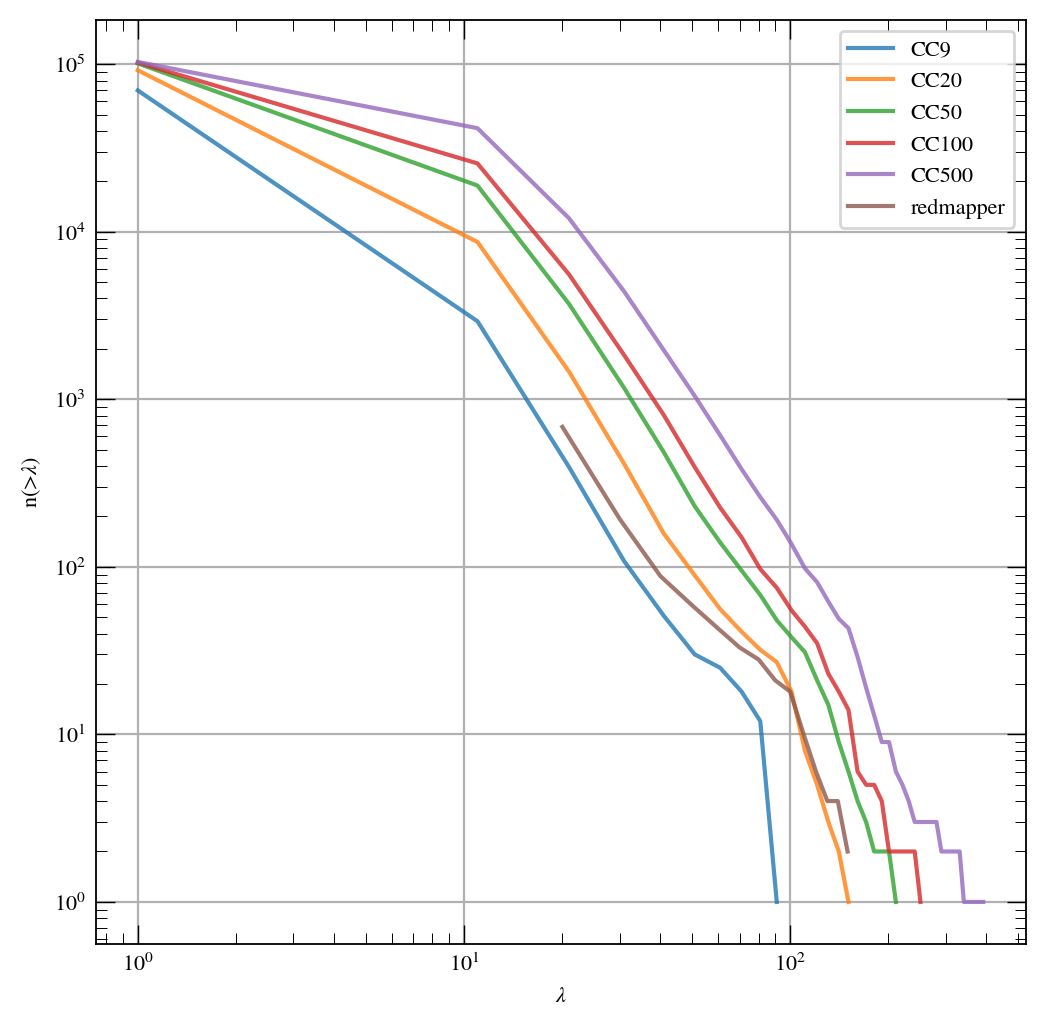

In [38]:
markers = ['o', 's', 'D','^','*', 'X', 'v'] ## , 

def n_greater_than_lambda(data):
    for i in range(len(data)):
        lambda_values = np.arange(data[i].min(), data[i].max(), 10)
#         print(lambda_values)
        n_greater_than_lambda = np.zeros(lambda_values.shape)
        for j in range(len(lambda_values)):
            n_greater_than_lambda[j] = np.count_nonzero(data[i] > lambda_values[j]) #/ len(data[i])
#         print(n_greater_than_lambda)
        plt.yscale('log')
        plt.xscale('log')
        plt.plot(lambda_values, n_greater_than_lambda, label=labels[i], alpha=0.8)

    plt.xlabel('$\lambda$')
    plt.ylabel('n(>$\lambda$)')
#     plt.xlim(20,None)
#     plt.ylim(None,4e3)
    plt.legend()
    plt.show()

# Generate some data
data = [clusterCC9['lam'], clusterCC20['lam'], clusterCC50['lam'], clusterCC100['lam'],clusterCC500['lam'], redmapper_filtd_un['lambda']]
labels = ['CC9', 'CC20', 'CC50', 'CC100', 'CC500', 'redmapper'] ## 'ZC0101', 'ZC0303', 'ZC11'

n_greater_than_lambda(data)


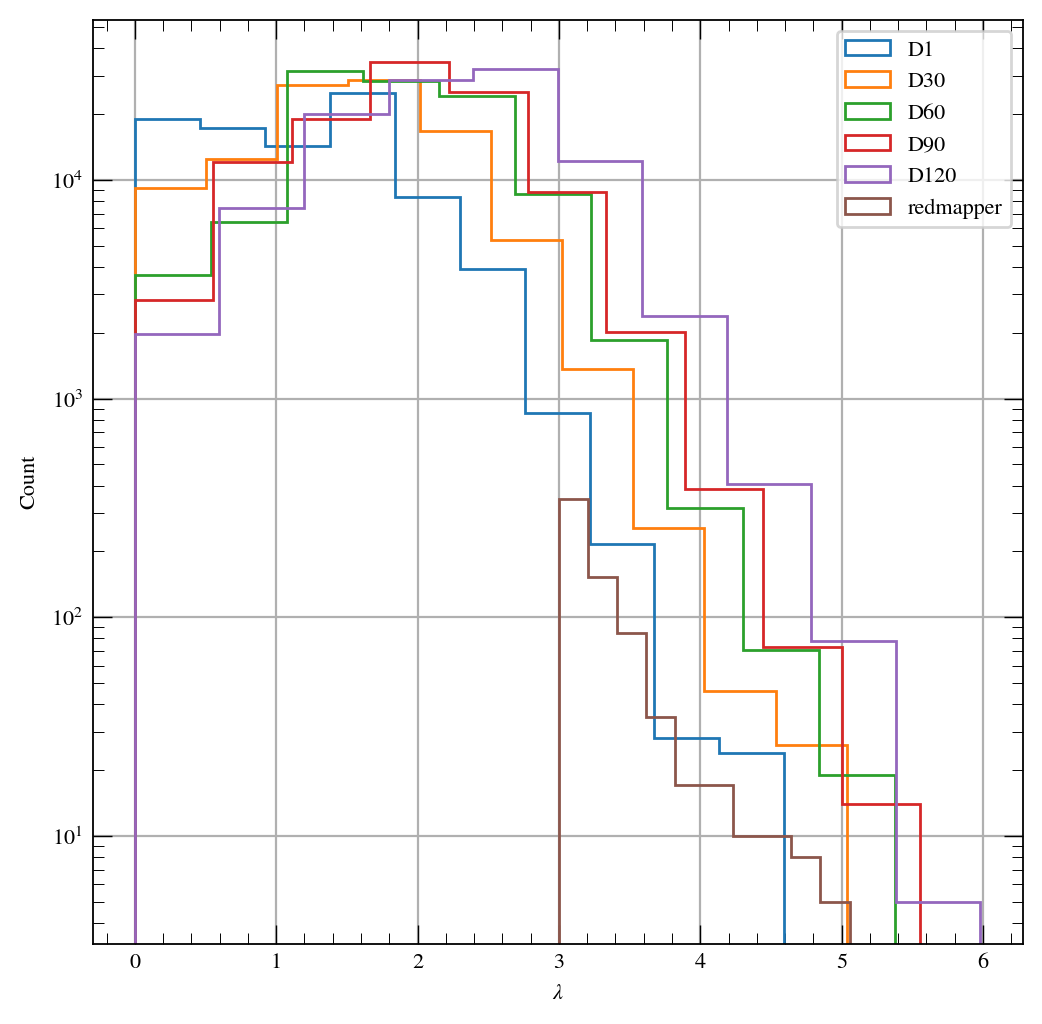

In [39]:
plt.hist(np.log(clusterCC9['lam']), label='D1',  histtype='step')
plt.hist(np.log(clusterCC20['lam']), label='D30', histtype='step')
plt.hist(np.log(clusterCC50['lam']), label='D60', alpha=1, histtype='step')
plt.hist(np.log(clusterCC100['lam']), label='D90',  histtype='step')
plt.hist(np.log(clusterCC500['lam']), label='D120',  histtype='step')
# plt.hist(np.log(clusterZC0101['lam']), label='ZC0101',  histtype='step')
# plt.hist(np.log(clusterZC0303['lam']), label='ZC0303',  histtype='step')
# plt.hist(np.log(clusterZC11['lam']), label='ZC11',  histtype='step')
plt.hist(np.log(redmapper_filtd_un['lambda']), label='redmapper',  histtype='step')

# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$')  # Adjusted to put 'lam' on the x-axis
plt.ylabel('Count')
plt.legend()
plt.show()